In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, fixed

# Lecture 3

**Topic:** Maximum Likelihood Estimation and Entropy

- Applies to both **supervised** & **unsupervised** learning
- MLE is for estimating model parameters / evaluating performance. 

### Key Questions 
1. How can we represent and sample from a distribution?
- A **distribution** forms the basis of modelling any data generation process.
- Know the distribution => Predict the structure of data
2. How do you estimate the parameters and evaluate the model?
- Using MLE
- allows us to fit our models to *real data*
3. Could MLE also be applied to supervised learning?
- Yes.
4. Summary + Housekeeping

### Lecture Objectives
At the end of the lecture, we should be able to:
1. Identify the PDF and parameters of distributions, relate it to their use in constructing likelihood functions.
- PDF/CDF: how we represent probability functions. 
- Understanding them = knowing how data is generated. 
2. Construct the **likelihood-function** for a dataset. Maximize it to find the **MLE** of the parameters. 
- MLE: to estimate parameters of distributions => to fit models to the data.
3. Define and apply information theoretic measures such as **entropy** and **KL** divergence to ***characterize and compare distributions***.
- Let's us quantify how well different models represent the data.
4. Demonstrate that *regression* can be viewed as a special case of MLE (using likelihood). 


# Supervised vs. Unsupervised Learning 


## Supervised

In both, the learning is **supervised** - we have access to the true outcomes during training.

### Classification 
- Seperating data into two distinct *clusters* (in *vector space*)
- Using an algorithm *(e.g. Perceptron)* to find the seperating hyperplane that partitions the data

### Regression 
- Fitting a line through data points to minimize distance to actual outcomes. 

![alt text](<img/Screenshot 2024-09-19 at 11.37.13.png>)

## Unsupervised 

Discovering patterns without labeled outcomes.

![Screenshot 2024-09-19 at 11.50.28.png](<attachment:Screenshot 2024-09-19 at 11.50.28.png>)

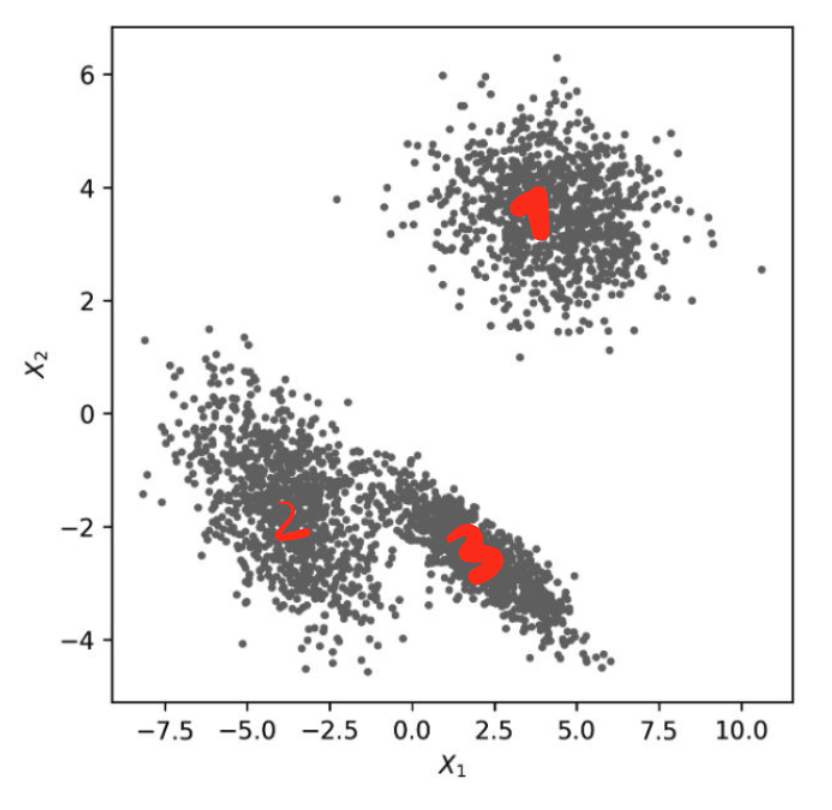

# Maximum Likelihood Estimation (MLE)

- Method we use to estimate the parameters of models that best explain what we observe. 
- Backbone of unsupervised learning techniques

# 1. How can we represent and sample from a distribution?

ANY DATASET can be thought of as coming from a distribution. 

### PDF : Probability Density Function

They must satisfy: sum of area = 1

$$
    \int_{-\infin}^{+\infin}{p(x)} = 1
$$

### CDF : Cumulative Distribution Function

Provides insight into the *probability mass* below a certain threshold

$$
    Pr(X \le \blue x) =  \int_{-\infin}^{\blue x}{p(\blue x)}
$$


## Normal (Gaussian) Distribution

### PDF
$$
    p(x) =
    \frac
        {1}
        {\sqrt{2\pi \red\sigma^2}}
    e^{
        - \frac{(x-\blue\mu)^2}{2\red\sigma^2}
    }
$$


In [ ]:
### PLOTTING NORMAL DISTRIBUTION AND CDF

def normal_distribution(x_min, x_max, mu, sig, samps=1000):
    X = np.linspace(x_min, x_max, samps)
    return [
        X,
        (1 / (sig * np.sqrt(2 * np.pi))) * np.exp(- (X - mu)**2 / (2 * sig**2))
    ]

def plot_normal(x: np.ndarray, y: np.ndarray, mu=0, sig=1):
    plt.plot(x, y)
    plt.vlines(mu, 0, y.max(), colors='b', linestyles='dashed')

    plt.xlabel("x")
    plt.ylabel("Probability Density")

def get_CDF(x: np.ndarray, y: np.ndarray):
    return np.cumsum(y) / np.sum(y)

def plot_cdf(x: np.ndarray, y: np.ndarray):
    plt.plot(x, y)
    plt.xlabel("x")
    plt.ylabel("Probability")

def plot_pdf_and_cdf(x, PDF, CDF, mu=0, sig=1):
    plot_normal(x, PDF, mu)
    plot_cdf(x, CDF)
    plt.legend(["PDF", "CDF"])
    plt.show()

def plot_pdf_cdf_interact(mu=0, sig=1):
    x, PDF = normal_distribution(-3, 3, mu, sig)
    CDF = get_CDF(x, PDF)
    plot_pdf_and_cdf(x, PDF, CDF, mu, sig)

interact(plot_pdf_cdf_interact, mu=(-3, 3, 0.1), sig=(0.1, 3, 0.1))

For a <u>Continous</u> Random Variable, X

$$
    X \sim N(\mu, \sigma^2)
$$

The **expectation** *(a.k.a, first moment)* of X is

$$
    E(x) = \int (xp(x))dx= \mu
$$

Which is essentially a weighted average, over the PDF. 
It's the center of mass of a distribution.

If X is discrete, we estimate the expectation w' a sample *(aka, empirical)* mean

$$
    E(x) = \frac{1}{n} \sum_{i=1}^{n} X_i
$$



### Inverse Transform Sampling 

If we know $X$ follows $N(\mu, \sigma^2)$, here's how we generate samples: 

1. Generate a random number $\in (0, 1)$
- Any # is equally likely in a uniform dist. 
2. Look up the uniform value on the y-axis of the CDF to find an $x$ value

The slope of the CDF => density of generated samples

This technique can be used w' any distribution.

In [ ]:
# EXAMPLE

def FindSampleUsingCDF(x: np.ndarray, CDF, prob):
    index: int = np.where(CDF >= prob)[0][0]
    x_val: int = x[index]
    return x_val

def interactive_cdf(x, CDF, prob=0.5):
    plot_cdf(x, CDF)
    x_val = FindSampleUsingCDF(x, CDF, prob)
    plt.vlines(x=[x_val], ymin=0, ymax=prob, colors='r')
    plt.hlines(y=prob, xmin=x.min(), xmax=x_val, colors='r')
    plt.text(x_val+0.1, 0, f"x={np.round(x_val, 1)}")

# GIVEN A CDF
x, PDF = normal_distribution(-5, 5, mu=0, sig=2)
CDF = get_CDF(x, PDF)
interact(interactive_cdf, x=fixed(x), CDF=fixed(CDF), prob=(0, 1, 0.01))


##  Normal Distribution for Multidimensional Data

$X$ is now a random *vector* $ \bold{X} \in \mathbb{R}^d$

Each component of $\bold{X}$ has its own mean & **variance**

The relationship between them is described by the **Covariance Matrix, $\Sigma$**

$X \sim N(\mu, \Sigma)$

$$
\begin{aligned}
    \Sigma &= Cov(\bold{X}) \\
    &= E[ (\bold{X}-E[\bold{X}])^T (\bold{X}-E[\bold{X}])] \\
    &= 
    \begin{bmatrix}
        Var(X_1) & Cov(X_1, X_2) & \dots & Cov(X_1, X_3) \\
        Cov(X_2, X_1)  & Var(X_2) & \dots &  Cov(X_2, X_d) \\ 
        \vdots & \vdots & \ddots & \vdots \\
        Cov(X_d, X_1) & Cov(X_d, X_2) & \dots &  Var(X_d) \\ 
    \end{bmatrix}
\end{aligned}
$$

Recall that if $X$ is discrete, $E[x]$ is calculated by summing over all $n$ samples.

In 2D: 

$$
\begin{aligned}
    \Sigma &= Cov(X = \langle x_1, x_2 \rangle ) 
    \\
    &= 
    E[ 
        ( \langle x_1, x_2 \rangle -  \langle \mu_1, \mu_2 \rangle )^T 
        ( \langle x_1, x_2 \rangle - \langle \mu_1, \mu_2 \rangle )
    ] 
    \\ 
    &= 
    E[ 
        ( \langle x_1 - \mu_1, x_2 - \mu_2 \rangle  )^T 
        ( \langle x_1 - \mu_1, x_2 - \mu_2 \rangle )
    ] 
    \\ 
    &= 
    E[ 
        \begin{bmatrix} 
            x_1 - \mu_1 \\
            x_2 - \mu_2 \\ 
        \end{bmatrix}
        \begin{bmatrix} 
            x_1 - \mu_1 & 
            x_2 - \mu_2
        \end{bmatrix}
    ] 
        \\ 
    &= 
    E[ 
        \begin{bmatrix} 
            (x_1 - \mu_1)^2             & (x_1 - \mu_1)(x_2 - \mu_2) \\ 
            (x_2 - \mu_2)(x_1 - \mu_1)  & (x_2 - \mu_2)^2
        \end{bmatrix}
    ] 
\end{aligned}
$$



### Covariance 
How much they change together 
- $Cov(X_1, X_2) > 0 \implies$ They increase together
- $Cov(X_1, X_2) < 0 \implies$ One increases while the other decreases
### Covariance Matrix

Always symmetric



### 2D Example

- **(+) Covariance:** Eliptical shape, tilted in the direction of the relationship.
- **(-) Covariance:** Same, but in the opposite direction
- **Small Covariance:** Not much correlation. 

In [55]:
# EXAMPLE


# Create an interactive plot

def Plot2DDataByCovMatrix(
    n: int = 100,
    var1: float = 1,
    var2: float = 1,
    cov: float = 0.5,
    mean_x1: float = 0,
    mean_x2: float = 0,
):
    '''
        n: number of samples
        var1: variance of x1
        var2: variance of x2
        cov: covariance between x1 and x2
    '''
    x1 = np.random.normal(mean_x1, np.sqrt(var1), n)
    x2 = (cov * x1) + np.random.normal(mean_x2, np.sqrt(var2), n)
    _, ax = plt.subplots(1,1)
    ax.scatter(x1, x2)
    ax.set_xlabel("x1"), ax.set_ylabel("x2")
    plt.show()

interact(Plot2DDataByCovMatrix, n=(10, 400), mean_x1=(-2, 2), mean_x2=(-2,2), var1=(0.1, 10, 0.1), var2=(0.1, 10, 0.1), cov=(-1, 1, 0.1))


interactive(children=(IntSlider(value=100, description='n', max=400, min=10), FloatSlider(value=1.0, descripti…

<function __main__.Plot2DDataByCovMatrix(n: int = 100, var1: float = 1, var2: float = 1, cov: float = 0.5, mean_x1: float = 0, mean_x2: float = 0)>

## How to estimate parameters & evaluate the model? 

(done) Find the hypothesis class (the PDF) \
(next) Estimate the parameters 

## Joint Density 

For 2 random variables, $X_1$ and $X_2$:

Joint PDF = Probability of both occuring = 

$$
    p(X_1, X_2) = p(X_1)p(X_2 | X_1)
$$

If *independent*: 

$$
    p(X_1, X_2) = p(X_1)p(X_2)
$$


We can view the *PDF* as "how likely it is to observe $x$ given $\mu$ and $\sigma$"

If all observations are independent: 

$$
    p(\bold{x} | \mu \sigma^2) 
    = \prod_{i=1}^n p(x_i| \mu \sigma^2)
    = \prod_{i=1}^n 
        \frac
            {1}
            {\sqrt{2\pi \red\sigma^2}}
        e^{
            - \frac{(x-\blue\mu)^2}{2\red\sigma^2}
        }
$$

### Visual

![Screenshot 2024-09-19 at 19.41.09.png](<attachment:Screenshot 2024-09-19 at 19.41.09.png>)

Each observation's PDF is shown. 

The joint PDF is shown in grey; P(all occuring).
- More narrow <= the estimate of the mean gets more and more certain as you multiply densities.


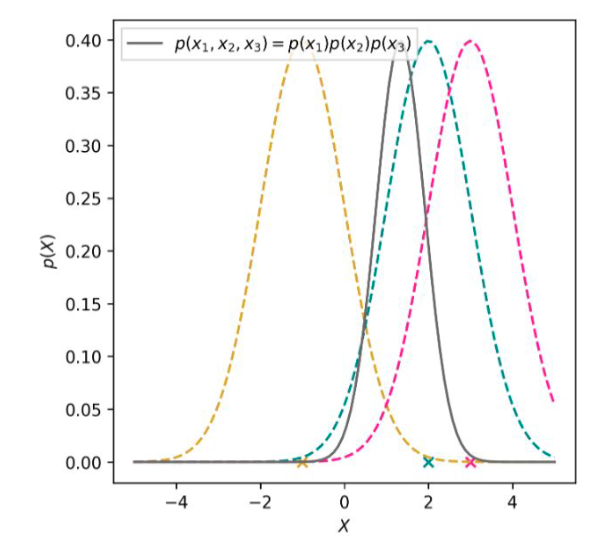

In [77]:
# EXAMPLE:

def plotJointProb(mean, var, x1, x2, x3):
    n = 100
    # PLOT A NORMAL DISTRIBUTION WITH MEAN & VAR
    x, Y = normal_distribution(-5, 5, mean, var, samps=n)
    jointProb = 1  # Initialize jointProb here
    print(x.min(), x.max())
    plt.plot(x, Y)

    def plotVline(x_val):
        nonlocal jointProb  # Ensure jointProb is accessible
        i = np.where(x >= x_val)[0][0]
        prob = Y[i]
        plt.vlines([x_val], colors='r', ymin=0, ymax=prob)
        jointProb *= prob

    plotVline(x1)
    plotVline(x2)
    plotVline(x3)

    plt.title('Joint Probability: ' + str(jointProb))
    jointProb = 1  # Initialize jointProb here
    print(x.min(), x.max())
    plt.plot(x, Y)

interact(plotJointProb, mean=(-3, 3, 0.1), var=(0.4, 3, 0.1), x1=(-3, 3, 0.1), x2=(-3, 3, 0.1), x3=(-3, 3, 0.1))


interactive(children=(FloatSlider(value=0.0, description='mean', max=3.0, min=-3.0), FloatSlider(value=1.70000…

<function __main__.plotJointProb(mean, var, x1, x2, x3)>

## Likelihood

**Joint Density**: probability of seing observations given parameters

$$p(\bold x| \mu, \sigma^2)$$

**Likelihood**: probability of the parameters given the observations

$$L(\mu, \sigma^2 | \bold x) = p(\bold x| \mu \sigma^2)$$

**Note:** For continous X, likelihood is NOT A PROBABILITY. It's a relative measure of how good the parameters match the data. 

### Ex: 

![Screenshot 2024-09-19 at 19.50.40.png](<attachment:Screenshot 2024-09-19 at 19.50.40.png>)

1. The likelihood is high => good params
2. The likelihood is low => bad params
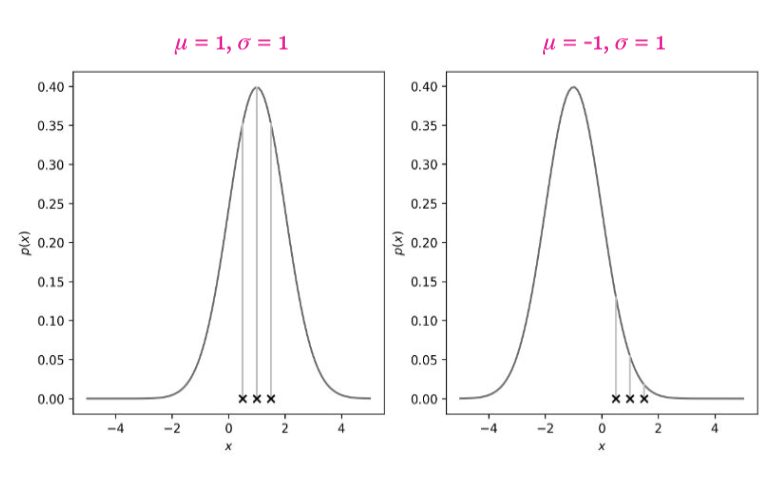

## Maximum Likelihood Estimation (MLE)

- (DONE) we can measure how good parameters are. 
- (NEXT) how do we determine the optimal parameters?

Finds the parameters that make the observed data most probable under the assumed model. 

### Derivation

**Assume:**

$n$ observations drawn from $N(\mu, \sigma^2)$

Maximize: 

$$
    L(\mu, \sigma^2 | \bold x)
    = \prod_{i=1}^n 
    \frac
        {1}
        {\sqrt{2\pi \red\sigma^2}}
    e^{
        - \frac{(x-\blue\mu)^2}{2\red\sigma^2}
    }
$$

1. log both sides
- **why?** because it turns a product into a sum - easier to evaluate, and it doesn't change the location of max.
2. Partial Derivative for each parameter
3. Set to 0
4. Use the empirical 

![Screenshot 2024-09-19 at 20.11.16.png](<attachment:Screenshot 2024-09-19 at 20.11.16.png>)

- The MLE estimate of $\sigma^2$  = std. def of $\sigma^2$
- The best estimate (empirical) of $\sigma^2$ = avg. squared deviation from mean

### Ex: 

Given, $\mu = -3, \sigma=1.5$:

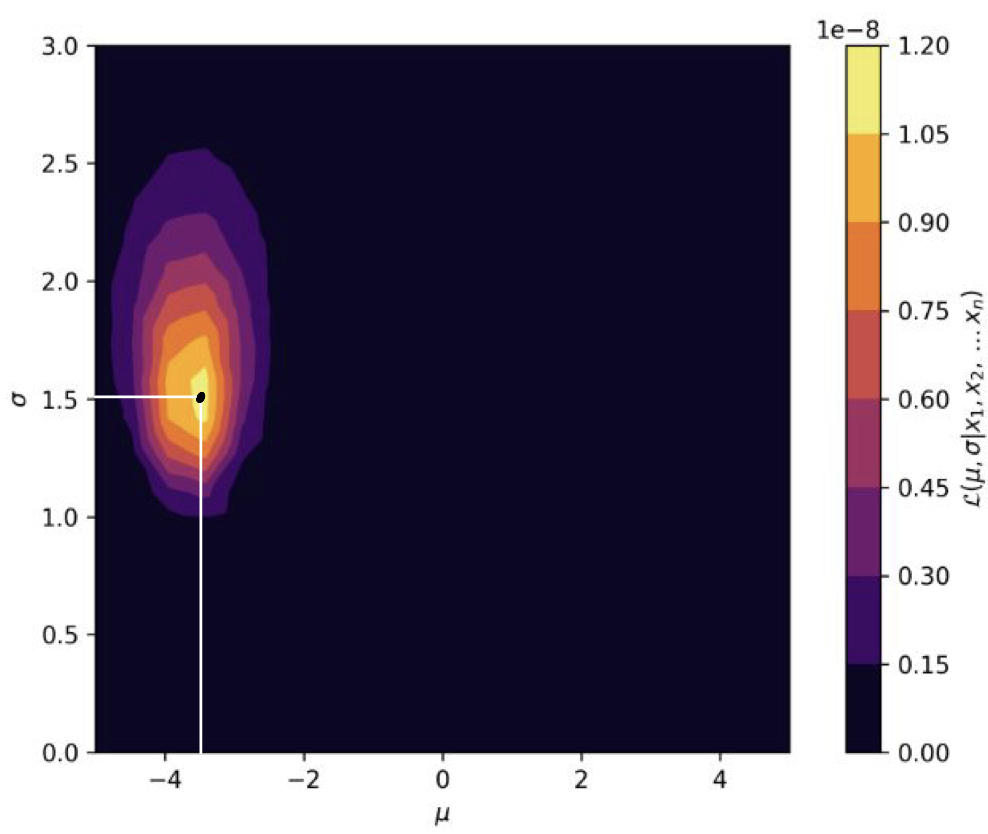
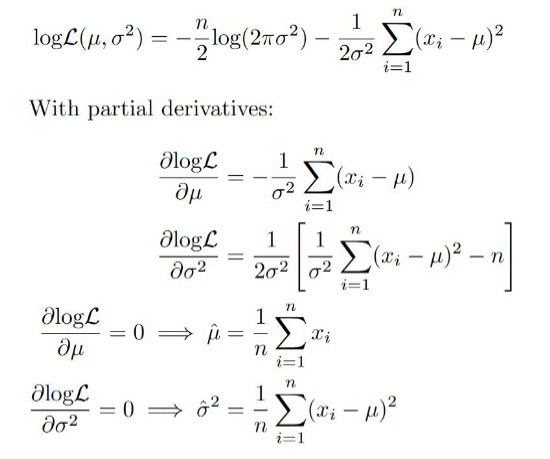

## Entropy

- (DONE) finding the params. that best explain data given the assumed model. 
- (NEXT) How do we compare this to the TRUE process that generates data. 

Quantifies uncertainty / randomness in a distribution = how unpredictable outcomes are. 

- Unpredictable = High Entropy

$$
\begin{aligned}
    h(X) &= E[-\log{p(X)}] \\
    &= - \sum_{i=1}^n Pr[x_i]\log{Pr[x_i]} \ \ \ \text{(for discrete)} \\
    &= - \int_{X} p(x)\log{p(x)}dx \ \ \ \text{(for continous)} \\
    &= - \frac{1}{2}log[2\pi e \sigma^2] \ \ \ \text{(for Normal)}
\end{aligned}
$$ 

Note: for normal dist, entropy depends only on variance.

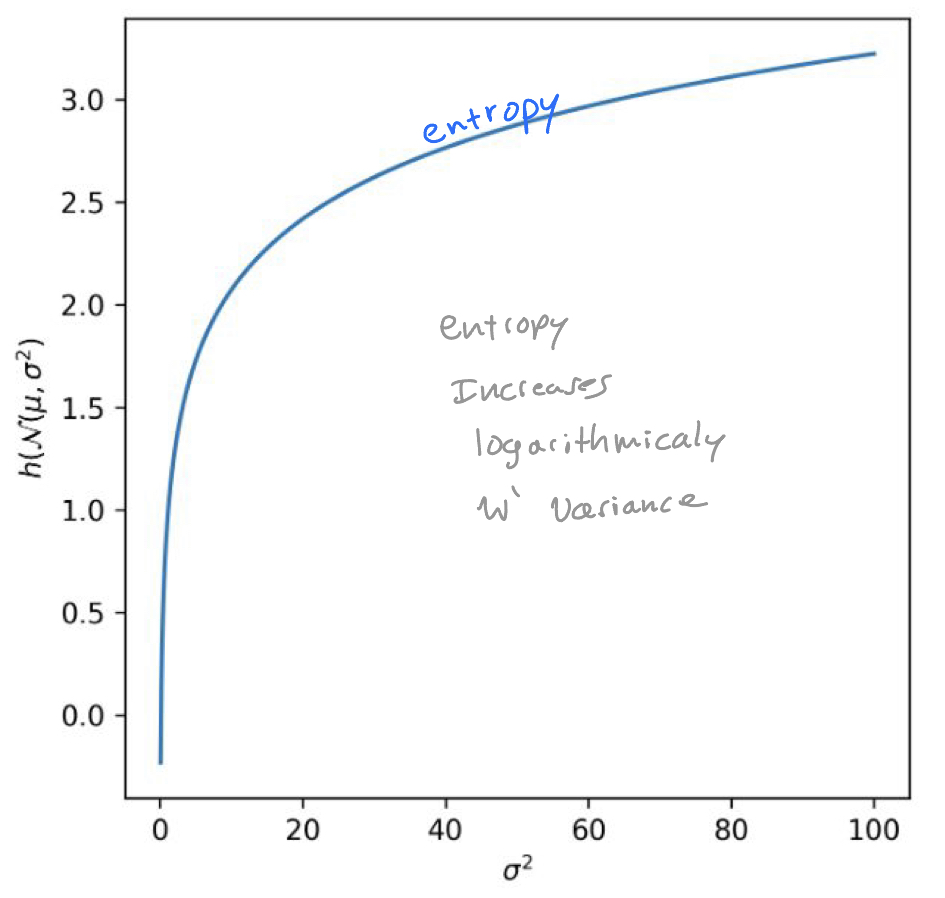

For a benoulli variable (2 outcomes) like a coin-flip: 

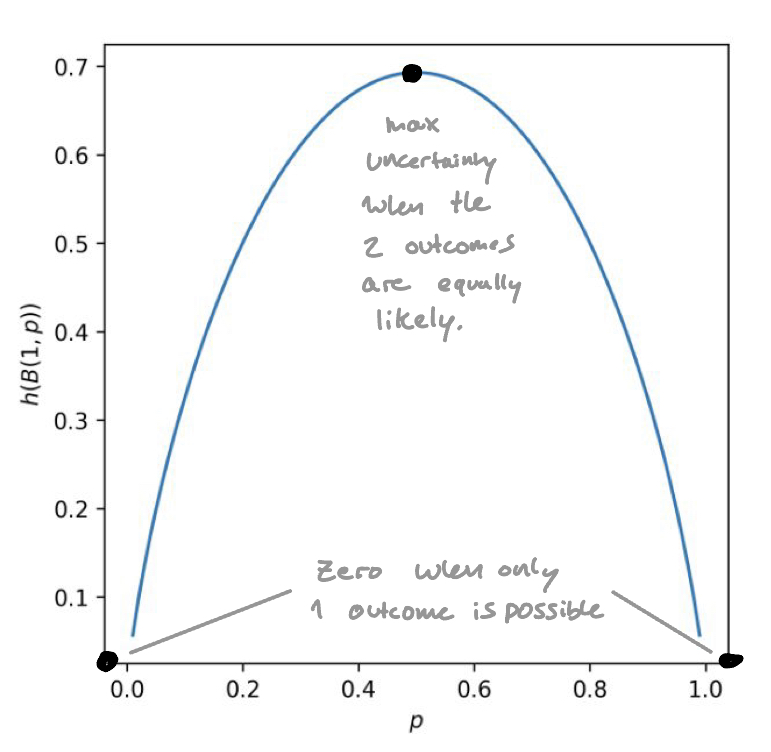

## Kullback-Leibler Divergence (KL)

- (DONE) Entropy = Uncertainty within a single distribution 
- (NEXT) How well 2 distributions match

KL \
= Relative Entropy \
= how a distribution **diverges** from a **reference** distribution \
= how surprised we would be of an outcome

Given: 

- P = Reference (real world)
- Q = Model (e.g. result of MLE)

$$
\begin{aligned}
    D_{KL}(P|Q) \\
    &= \sum_{x\in X} P(x) \log \frac{P(x)}{Q(x)} \ \ \ \text{(discrete)} \\ 
    &= \int p(x) \log \frac{p(x)}{q(x)} dx \ \ \ \text{(continous)}
\end{aligned}
$$

KL = (probability-mass for an outcome under reference) * (log( mass under reference / mass under model))

In [ ]:
# EXAMPLE
import numpy as np
import math
# P (binomial distribution)
n = 2
p = 0.4
X = np.arange(0, n+1) # 3 outcomes: 0, 1, 2
P = np.array([math.comb(n, x) * p**x * (1 - p)**(n - x) for x in X])

# Q (Uniform distribution)
Q = [1/3 for i in range(n+1)]

# 2 seperate plots, same figure
fig, axes = plt.subplots(1, 3)
# space out the subplots a bit
fig.tight_layout()
# plot Q and P on seperate axes
axes[0].bar(X, P)
axes[0].set_title("P")

axes[1].bar(X, Q)
axes[1].set_title("Q")


def KL_divergence(P, Q, X):
    return [P[x] * math.log(P[x] / Q[x]) for x in X]

D_KL = KL_divergence(P, Q, X)
axes[2].bar(X, D_KL)
axes[2].set_title("D_KL")


# Applying MLE to Supervised Learning? 

## MLE & Linear Regression

TO DO